# WIP: First Verification Study of Orchestration Runtime

The implementation of the runtime has reached a reasonable point and I would like to pause to do a careful study of the correctness of the runtime as well as get an initial understanding of its runtime performance/overheads.

## Lab notes
-----------
#### 3 April 2020
* Setup googletest and AMReX libraries in Summit using gcc-9.1.0

#### 15 April 2020
* Using gcc-9.1.0 for all builds and tests carried out here
```
Currently Loaded Modules:
1) hsi/5.0.2.p5   2) xalt/1.2.0   3) lsf-tools/2.0   4) DefApps   5) cuda/10.1.243   6) git/2.13.0
7) gcc/9.1.0   8) cmake/3.15.2   9) spectrum-mpi/10.3.1.2-20200121  10) hdf5/1.8.18
```
* Built 2D AMReX from commit `1838cd85` on master branch
   a. Uses MPI and Fortran interface
   b. No OpenMP, CUDA, or OpenACC
* Updated all FLASH5 branches and checked out master (commit `1a72f258`)
* Altered summit gcc Makefile locally to use my AMReX libraries (`~/local/gcc_9.1.0/AMReX_2d`)
* Built Sod problem, for which I have a Summit PGI baseline, so that I can verify AMReX build.
```
./setup Sod -makefile=gcc -auto -2d -debug +uhd -nxb=8 -nyb=8 -parfile=test_amr_unsplit_2d.par --unit=Grid/GridMain/AMR/Amrex +serialio --unit=IO/IOMain/hdf5/serial/AM --index-reorder -portable
```
* Launched job using 6 resource sets with 1 rank/RS and 7 cores/rank (Job ID 36623)
  * Results look good in Visit and E_total and mass were conserved
* Updated master branch in OrchestrationRuntime (commit `b3d80f80`)
* __ON `hello`__: Using same OrchestrationRuntime commit, built and ran new ManualTestCpp test.  Ran and watched using Activity Monitor the number of threads for the test to see how threads are being created and destroyed.  __It appears that AMReX has orphaned a thread somehow.  It also seems strange that we have 3 threads after AMReX intialization and then only 2 after the Grid initialization.__  However, it seems that we are getting reasonable thread usage by the ThreadTeam and OrchestrationRuntime.  Confirmed this by commenting out the actions that require AMReX.  Without AMReX, we end up with only a single thread as expected.

| Action            | N Expected Threads | N Actual Threads |
|:-----------------:|:------------------:|:----------------:|
| Start program     | 1                  | 1                |
| Create ThreadTeam | 5                  | 5                |
| Run ThreadTeam    | 5                  | 5                |
| Delete ThreadTeam | 1                  | 1                |
| Initialize AMReX  | 1 + [0, ?]         | 3                |
| Initialize Grid   | 1 + [0, ?]         | Max 6 / 2 at end |
| Create OR         | 1 + 12 + [0, ?]    | 14               |
| Delete OR         | 1 + [0, ?]         | 2                |
| Finalize AMReX    | 1                  | __2__            |
| End program       | 1                  | __2__            |

* Deleted all binaries in summit sites folder
* `./buildTestThreadTeamCpp.sh &> buildTestThreadTeamCpp_2020-04-15.log`
* `./buildTestRuntimeCpp.sh &> buildTestRuntimeCpp_2020-04-15.log`
* `./buildGatherDataCpp.sh &> buildGatherDataCpp_2020-04-15.log`
* Updated so that `testThreadTeam_lsf` the log files can be written to file appropriately in Summit's file system (commit `19de5435`)
* Launched `testThreadTeam_lsf` (Job ID 36789)
* `./buildGatherDataF2003.sh &> buildGatherDataF2003_2020-04-15.log`
* Updated so that `testRuntimeCpp_lsf` the log files can be written to file appropriately in Summit's file system (commit `0076be24`)
* Launched `testRuntimeCpp_lsf` (Job ID 36822)
* Launched `gatherDataCpp_lsf` (Job ID 36832)
* Launched `gatherDataF2003_lsf` (Job ID 36921)
* Manually verified that the contents of `TestDestruction.log` are correct
* Manually verified that the contents of `TestSingle_ManualCheck.log` are correct

#### 17 April 2020
* Updated the ThreadTeam startTask routine so that it only returns once the given number of threads, N, have actually been activated.  Updated the ThreadTeam timing test to use this facility so that now we can get a better quality estimation of the ThreadTeam overhead.  Commit `9f92b1fe3`.
* Using gcc-9.1.0 for all builds and tests carried out here
```
Currently Loaded Modules:
  1) hsi/5.0.2.p5   2) xalt/1.2.0   3) lsf-tools/2.0   4) DefApps   5) git/2.13.0   6) gcc/9.1.0   7) spectrum-mpi/10.3.1.2-20200121
```
* Reacquired ThreadTeam test data on Summit (Job ID 42091).

#### 20 April 2020
* Improved the ThreadTeam test in terms of rigor and data collected.  It now gets timing information for just startTask and just closeTask (when no work is given).  Commit `0c5f4286`.
* Reacquired ThreadTeam test data on Summit (Job ID 46496).

#### 30 April 2020
* Improved the test so that the scaling action routine now incorporates coordinates $x,y$.  The test is improved because it is now sensitive to the order in which approximating the Laplacian and scaling are applied by two ThreadTeam's interconnected as work publisher/subscriber.  This should also increase the runtime of the action routine so that it is at least a little closer to a standard action routine.  Commit `bb295885`.
* Using gcc-9.1.0 for all builds and tests carried out here
```
Currently Loaded Modules:
  1) hsi/5.0.2.p5   2) xalt/1.2.0   3) lsf-tools/2.0   4) DefApps   5) git/2.13.0   6) gcc/9.1.0   7) spectrum-mpi/10.3.1.2-20200121
```
* Rebuilt and reran ThreadTeam test (Job ID 65460)
* Rebuilt and reran RuntimeCpp test (Job ID 65461)
* Rebuilt and reran gatherDataF2003 (Job ID 65463)
* Rebuilt and reran gatherDataCpp test (Job ID 65489)

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import datetime as dt
import itertools as it
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from pathlib import Path
from platform import python_version
from matplotlib import __version__ as plt_version

plt.style.use('ggplot')

FONTSIZE = 16

print()
print('Reproducibility Metadata')
print('-' * 60)
print(f'Started execution at {dt.datetime.now()}')
print(f'python     version\t{python_version()}')
print(f'numpy      version\t{np.__version__}')
print(f'scipy      version\t{sp.__version__}')
print(f'pandas     version\t{pd.__version__}')
print(f'matplotlib version\t{plt_version}')

#####----- ThreadTeam timing test specification
N_TT_TRIALS = 5000
TT_JOB_ID = 249429
TT_PATH = Path(f'testThreadTeam_{TT_JOB_ID}')

#####----- gatherDataCpp test specification
N_GATHER_CPP_TRIALS = 5
GATHER_CPP_JOB_ID = 249560
GATHER_CPP_PATH = Path(f'gatherDataCpp_{GATHER_CPP_JOB_ID}')
GATHER_CPP_SERIAL_THOLD_SEC = 2.0e-3

#####----- gatherDataF2003 test specification
N_GATHER_F03_TRIALS = 1
GATHER_F03_JOB_ID = 249437
GATHER_F03_PATH = Path(f'gatherDataF2003_{GATHER_F03_JOB_ID}')


Reproducibility Metadata
------------------------------------------------------------
Started execution at 2020-07-28 08:05:30.884096
python     version	3.7.7
numpy      version	1.18.5
scipy      version	1.5.0
pandas     version	1.0.5
matplotlib version	3.2.2


## The Test Problem
---------

The test problem
1. is defined on the square domain $\Omega = [0, 1] \times [0, 1]$,
2. must be discretized such that $\delta x = \delta y$, and
3. the domain decompositions must satisfy $N_B^x = N_B^y$,

where point (2) is used to simplify the numerical discretization of the Laplacian and (3) simplifies the timing analysis.  The data defined on the domain for the problem is "density" and "energy" with 
\\[
\rho(x,y) = 3x^3 + x^2 + x - 2y^3 - \frac{3}{2}y^2 + y + 5\\
E(x,y) = 4x^4 - 3x^3 + 2x^2 - x - y^4 + 2y^3 - 3y^2 + 4y + 1.
\\]

The problem is simply to approximate
\\[
f_{\rho}(x,y) = \Delta \rho(x, y)
\\]
and
\\[
f_E(x,y) = 5xy\Delta E(x, y)
\\]
for all $(x,y)$ in the discretization of $\Omega$ using the second-order approximation to the Laplacian.  Specifically, for a smooth function $f$, we know that there exists $(\xi_x, \xi_y) \in (x, x+\delta x)\times(y, y+\delta y)$ such that
\\[
\Delta f(x,y) = \frac{1}{\delta x^2}\left(\right) + \frac{1}{\delta y^2}\left(\right).
\\]

Note that $\rho$ was chosen so that the truncation error of the second-order Laplacian is zero; $E$, to have non-zero truncation error.  Also, the computation applied to $E$ was designed so that
\\[
f_E(x,y) = T\circ S \left(E(x,y)\right)
\\]
can be carried out in the two stages
\\[
g(x,y) = S \left(E(x,y)\right) = \Delta E(x,y)\\
f_E(x,y) = T \left(g(x,y)\right).
\\]
Note that 
\\[
T\circ S \left(E(x,y)\right) \not= S\circ T \left(E(x,y)\right),
\\]
which will help confirm proper in-order application of actions (_i.e._ $T, S$) to domain data $E$ by two thread teams connected as work subscriber and publisher.  The known solutions are
\\[
f_{\rho}(x,y) = 18x - 12y - 1\\
f_E(x,y) = 5xy\left(48x^2 - 18x - 12y^2 + 12y - 2\right).
\\]

## The Runtime Setup
---------
For the full, parallel execution of the problem using the runtime, the runtime is equipped with thread teams arranged such that a concurrent work distributor feeds blocks of domain data directly to Teams A and B.  Team A is assigned the action of applying the Laplacian to density; Team B, applying the Laplacian to energy.  Team C is connected to Team B as both a work and thread subscriber and to Team A as a thread subscriber.  This configuration means that Team C applies its action $T$ only after the Laplacian has been approximated.

## Miscellaneous Setup Code
---------

In [2]:
def customize_speedup_cmap(max_speedup, N):
    """
    Based on matplotlib's seismic colormap.
    """
    if max_speedup < 1.0:
        raise ValueError('The maximum speedup must be at least one')

    no_speedup = 1.0 / max_speedup

    a_m1 = 0.5 * no_speedup
    a_0  = no_speedup
    a_p1 = 0.5 * (1.0 + no_speedup)
    assert(0.0 <= a_m1 <= 1.0)
    assert(0.0 <= a_0  <= 1.0)
    assert(0.0 <= a_p1 <= 1.0)

    # Rescale the matplotlib seismic colormap so that we get white at no speedup
    # This will give shades of blue for slowdowns and shades of red for speedups.
    cdict = {'red':   [[0.0,  0.0, 0.0],
                       [a_m1, 0.0, 0.0],
                       [a_0,  1.0, 1.0],
                       [a_p1, 1.0, 1.0],
                       [1.0,  0.5, 0.5]],
             'green': [[0.0,  0.0, 0.0],
                       [a_m1, 0.0, 0.0],
                       [a_0,  1.0, 1.0],
                       [a_p1, 0.0, 0.0],
                       [1.0,  0.0, 0.0]],
             'blue':  [[0.0,  0.3, 0.3],
                       [a_m1, 1.0, 1.0],
                       [a_0,  1.0, 1.0],
                       [a_p1, 0.0, 0.0],
                       [1.0,  0.0, 0.0]]}

    return mcolors.LinearSegmentedColormap('speedup', segmentdata=cdict, N=N)

## Gather Data
------------
#### ThreadTeam timing results

In [3]:
# Assemble all raw results in single DataFrame
for j, fname in enumerate(TT_PATH.glob('StartCycleTimings_*_threads.dat')):
    tmp_df = pd.read_csv(fname, comment="#")
    tmp_df['test'] = 'startTask'
    if j == 0:
        TT_df = tmp_df.copy()
    else:
        TT_df = pd.concat([TT_df, tmp_df], ignore_index=True)

for fname in TT_PATH.glob('CloseQueueTimings_*_threads.dat'):
    tmp_df = pd.read_csv(fname, comment="#")
    tmp_df['test'] = 'closeTask'
    TT_df = pd.concat([TT_df, tmp_df], ignore_index=True)
    
for fname in TT_PATH.glob('NoWorkTimings_*_threads.dat'):
    tmp_df = pd.read_csv(fname, comment="#")
    tmp_df['test'] = 'NoWorkCycle'
    TT_df = pd.concat([TT_df, tmp_df], ignore_index=True)
    
for fname in TT_PATH.glob('FullCycleTimings_*_threads.dat'):
    tmp_df = pd.read_csv(fname, comment="#")
    tmp_df['test'] = 'FullCycle'
    TT_df = pd.concat([TT_df, tmp_df], ignore_index=True)

# Assemble aggregate results in dedicated DataFrames
columns = ['n_threads', 'mean_wtime_us', 'std_wtime_us']

N_threads_all = sorted(TT_df.N_threads.unique())
data = np.zeros([len(N_threads_all), 3])
for j, N_threads in enumerate(N_threads_all):
    df = TT_df[(TT_df.test == 'startTask') & (TT_df.N_threads == N_threads)]
    assert(len(df) == N_TT_TRIALS)
    assert(len(df.N_work.unique()) == 1)
    assert(df.iloc[0].N_work == 0)

    data[j, 0] = N_threads
    data[j, 1] = df.wtime_us.mean()
    data[j, 2] = df.wtime_us.std()
startTask_df = pd.DataFrame(data=data, columns=columns)
startTask_df['n_threads'] = startTask_df.n_threads.astype(int)

data = np.zeros([len(N_threads_all), 3])
for j, N_threads in enumerate(N_threads_all):
    df = TT_df[(TT_df.test == 'closeTask') & (TT_df.N_threads == N_threads)]
    assert(len(df) == N_TT_TRIALS)
    assert(len(df.N_work.unique()) == 1)
    assert(df.iloc[0].N_work == 0)

    data[j, 0] = N_threads
    data[j, 1] = df.wtime_us.mean()
    data[j, 2] = df.wtime_us.std()
closeTask_df = pd.DataFrame(data=data, columns=columns)
closeTask_df['n_threads'] = closeTask_df.n_threads.astype(int)

data = np.zeros([len(N_threads_all), 3])
for j, N_threads in enumerate(N_threads_all):
    df = TT_df[  (TT_df.test == 'FullCycle') \
               & (TT_df.N_threads == N_threads) \
               & (TT_df.N_work == 100)]
    if N_threads > 0:
        assert(len(df) == N_TT_TRIALS)

    data[j, 0] = N_threads
    data[j, 1] = df.wtime_us.mean()
    data[j, 2] = df.wtime_us.std()
work_df = pd.DataFrame(data=data, columns=columns)
work_df = work_df[work_df.n_threads > 0]
work_df['n_threads'] = work_df.n_threads.astype(int)

#### C++ & Fortran Orchestration Runtime timing results

In [4]:
# Collect all raw data in single DataFrame
for j, fname in enumerate(GATHER_CPP_PATH.glob('gatherDataCpp_*_*_*_*_*_*.dat')):
    tmp_df = pd.read_csv(fname, comment="#")
    if j == 0:
        cpp_full_df = tmp_df.copy()
    else:
        cpp_full_df = pd.concat([cpp_full_df, tmp_df], ignore_index=True)
cpp_full_df = cpp_full_df.fillna(0.0)
cpp_full_df['n_thd_task1'] = cpp_full_df.n_thd_task1.astype(int)
cpp_full_df['n_thd_task2'] = cpp_full_df.n_thd_task2.astype(int)
cpp_full_df['n_thd_task3'] = cpp_full_df.n_thd_task3.astype(int)
        
# These define the different timing experiment runs
setups = ['pmode', 'n_loops', \
          'n_thd_task1', 'n_thd_task2', 'n_thd_task3', \
          'NXB', 'N_BLOCKS_X']

columns =    setups \
          + ['dx', 'Linf_density', 'Linf_energy']

# Create DataFrame of aggregate results
groups = cpp_full_df.groupby(setups).groups
for j, key in enumerate(groups):
    df = cpp_full_df.loc[groups[key]]
    assert(len(df) == N_GATHER_CPP_TRIALS)

    # Confirm that the only data that differs is the timing data
    # and that all expectations are met
    assert(len(df.NYB.unique()) == 1)
    assert(df.iloc[0].NXB == df.iloc[0].NYB)

    assert(len(df.NZB.unique()) == 1)
    assert(df.iloc[0].NZB == 1)

    assert(len(df.N_BLOCKS_Y.unique()) == 1)
    assert(df.iloc[0].N_BLOCKS_X == df.iloc[0].N_BLOCKS_Y)

    assert(len(df.N_BLOCKS_Z.unique()) == 1)
    assert(df.iloc[0].N_BLOCKS_Z == 1)

    assert(len(df.dx.unique()) == 1)
    assert(len(df.dy.unique()) == 1)
    assert(df.iloc[0].dx == df.iloc[0].dy)

    assert(len(df.Linf_density.unique()) == 1)
    assert(df.iloc[0].Linf_density < 1.0e-15)

    data = {}
    for each in columns:
        assert(each not in data)
        data[each] = [df.iloc[0][each]]

    data['wtime_min']  = [df.Walltime_sec.min()]
    data['wtime_mean'] = [df.Walltime_sec.mean()]
    data['wtime_max']  = [df.Walltime_sec.max()]
    data['wtime_std']  = [df.Walltime_sec.std()]
    
    tmp_df = pd.DataFrame(data=data)
    if j == 0:
        cpp_df = tmp_df.copy()
    else:
        cpp_df = cpp_df.append(tmp_df, ignore_index=True)

cpp_df['n_thd_task1'] = cpp_df.n_thd_task1.astype(int)
cpp_df['n_thd_task2'] = cpp_df.n_thd_task2.astype(int)
cpp_df['n_thd_task3'] = cpp_df.n_thd_task3.astype(int)

for j, fname in enumerate(GATHER_F03_PATH.glob('gatherDataF2003_*_*_*_*_*_*.dat')):
    tmp_df = pd.read_csv(fname, comment="#")
    if j == 0:
        f03_full_df = tmp_df.copy()
    else:
        f03_full_df = pd.concat([f03_full_df, tmp_df], ignore_index=True)

# Confirm expectations for Fortran data
assert(len(f03_full_df.pmode.unique()) == 1)
assert(f03_full_df.iloc[0].pmode == 'Runtime')

assert(len(f03_full_df.n_loops.unique()) == 1)
assert(f03_full_df.iloc[0].n_loops == 1)

assert(len(f03_full_df.n_thd_task1.unique()) == 1)
assert(len(f03_full_df.n_thd_task2.unique()) == 1)
assert(len(f03_full_df.n_thd_task3.unique()) == 1)

assert(all(f03_full_df.NXB == f03_full_df.NYB))
assert(all(f03_full_df.dx == f03_full_df.dy))

assert(len(f03_full_df.NZB.unique()) == 1)
assert(f03_full_df.iloc[0].NZB == 1)

assert(len(f03_full_df.N_BLOCKS_Z.unique()) == 1)
assert(f03_full_df.iloc[0].N_BLOCKS_Z == 1)

assert(len(f03_full_df.Linf_density.unique()) == 1)
assert(f03_full_df.iloc[0].Linf_density < 1.0e-15)

for nxb in sorted(f03_full_df.NXB.unique()):
    df = f03_full_df[f03_full_df.NXB == nxb]
    assert(len(df) == N_GATHER_F03_TRIALS)

## Confirm Proper Scaling
--------

Energy Convergence Order (C++)	1.9908309293846622
Energy Convergence Order (F03)	1.9908309293846622


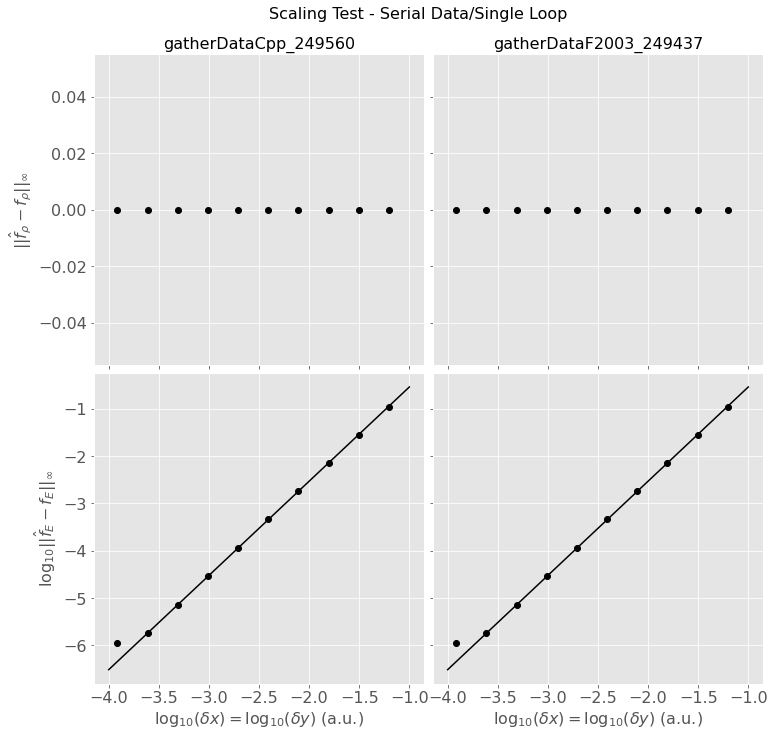

In [5]:
# Data at smallest mesh spacing is dominated by noise
START_IDX = 1

df = cpp_df[(cpp_df.pmode == 'Serial') & (cpp_df.n_loops == 1)]

# Data was intentionally acquired across the Cartesian product of
# NXB x N_BLOCKS_X.  As a result, there are different setups in the 
# product that yield the same dx = dy.  The errors should be identical for 
# all results with the same dx.  Therefore, we need only get one for each dx.
#
# Collect in order so that we can filter out for the linear least-squares fit
# the smallest dx results where noise begins to dominate.
dx_all = sorted(df.dx.unique())
n_dx = len(dx_all)

Linf_density_cpp = np.full(n_dx, 0.0, dtype=float)
Linf_energy_cpp  = np.full(n_dx, 0.0, dtype=float)
for j, dx in enumerate(dx_all):
    tmp_df = df[df.dx == dx]
    Linf_density_cpp[j] = tmp_df.Linf_density.iloc[0]
    Linf_energy_cpp[j]  = tmp_df.Linf_energy.iloc[0]

assert(dx_all == sorted(f03_full_df.dx.unique()))
Linf_density_f03 = np.full(n_dx, 0.0, dtype=float)
Linf_energy_f03  = np.full(n_dx, 0.0, dtype=float)
for j, dx in enumerate(dx_all):
    tmp_df = f03_full_df[f03_full_df.dx == dx]
    assert(len(tmp_df) == N_GATHER_F03_TRIALS)
    Linf_density_f03[j] = tmp_df.Linf_density.iloc[0]
    Linf_energy_f03[j]  = tmp_df.Linf_energy.iloc[0]

fit_cpp = np.polyfit(np.log10(dx_all[START_IDX:]), \
                     np.log10(Linf_energy_cpp[START_IDX:]), 1)
print('Energy Convergence Order (C++)\t{}'.format(fit_cpp[0]))

fit_f03 = np.polyfit(np.log10(dx_all[START_IDX:]), \
                     np.log10(Linf_energy_f03[START_IDX:]), 1)
print('Energy Convergence Order (F03)\t{}'.format(fit_f03[0]))

X_DATA = range(-4, 0)

plt.figure(2, figsize=(12, 11))
plt.suptitle('Scaling Test - Serial Data/Single Loop', fontsize=FONTSIZE)
plt.subplots_adjust(top=0.92, hspace=0.025, wspace=0.025)

subp1 = plt.subplot(221)
plt.title(GATHER_CPP_PATH, fontsize=FONTSIZE)
plt.plot(np.log10(dx_all), Linf_density_cpp, 'ok')
plt.ylabel(r'$||\hat{f}_{\rho} - f_{\rho}||_{\infty}$', fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_visible(False)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)

plt.subplot(222, sharex=subp1, sharey=subp1)
plt.title(GATHER_F03_PATH, fontsize=FONTSIZE)
plt.plot(np.log10(dx_all), Linf_density_f03, 'ok')
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_visible(False)
for each in plt.gca().get_yticklabels():
    each.set_visible(False)
    
subp2 = plt.subplot(223, sharex=subp1)
plt.plot(np.log10(dx_all), np.log10(Linf_energy_cpp), 'ok')
plt.plot(X_DATA, np.polyval(fit_cpp, X_DATA), '-k')
plt.xlabel(r'$\log_{10}(\delta x) = \log_{10}(\delta y)$ (a.u.)', fontsize=FONTSIZE)
plt.ylabel(r'$\log_{10} ||\hat{f}_{E} - f_{E}||_{\infty}$', fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)

plt.subplot(224, sharex=subp1, sharey=subp2)
plt.plot(np.log10(dx_all), np.log10(Linf_energy_f03), 'ok')
plt.plot(X_DATA, np.polyval(fit_f03, X_DATA), '-k')
plt.xlabel(r'$\log_{10}(\delta x) = \log_{10}(\delta y)$ (a.u.)', fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_visible(False)

## Examine ThreadTeam Overheads
---------
Use the results of the ThreadTeam timing test.

NOTE: If you include 1 in the basis for the function space, the condition number is somewhat large (1.5377e+07) and a poor value is found for the coordinate associated with that basis element.  This is clearly seen as the walltime predictions for small NXB and N_BLOCKS_X becomes negative.  In fact, the coordinate itself is negative and has a large magnitude, which is too far from the interpretation of the coordinate as a (hopefully) negligible walltime.  The norm of the residual is 0.00017723.

If you exclude 1 from the basis, the fit is very good across all data points.  The norm of the residual is 0.000179328, which is only slightly larger than for the poorly-conditioned model.  I believe that the explanation for the need to use a smaller function space is that the current data set does not contain points that help fix the constant coordinate => ill-conditioned.  The problem is too close to singular and the fit finds a single solution out of many possible solutions (i.e. norm of residual similar) that happens to be quite poor.

It could be that if we retool the code so that $\alpha_L, \beta_L$ are strongly decreased that we would sample data where $\alpha_S$ is __not__ negligible.  In such a case the larger function space would be necessary.


startTask Overhead
--------------------------------------------------------------------------------
Actual Zero-thread overhead	0.4936233999999994 +/- 0.4981691203466303 us
Predicted Zero-thread overhead	2.950 us
Overhead growth rate		4.759 us per thread

closeTask Overhead
--------------------------------------------------------------------------------
Actual Zero-thread overhead	0.6010930000000012 +/- 0.015507599689494915 us
Predicted Zero-thread overhead	4.549 us
Overhead growth rate		3.320 us per thread



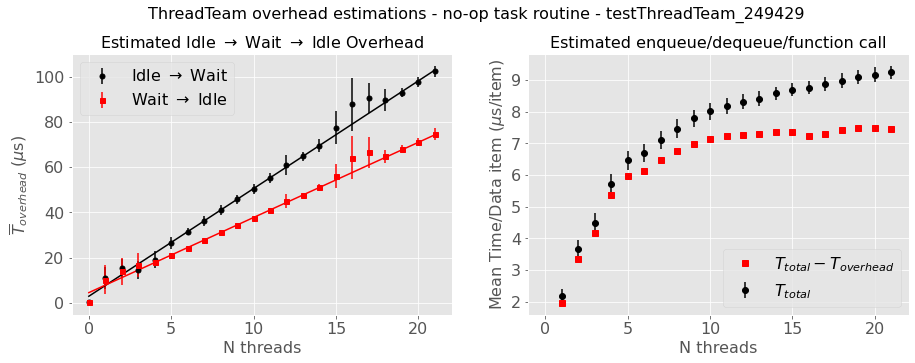

In [6]:
START_IDX = 1
fit_start = np.polyfit(startTask_df.n_threads.values[START_IDX:], \
                       startTask_df.mean_wtime_us.values[START_IDX:], \
                       w=1.0 / startTask_df.std_wtime_us[START_IDX:], \
                       deg=1)
fit_close = np.polyfit(closeTask_df.n_threads.values[START_IDX:], \
                       closeTask_df.mean_wtime_us.values[START_IDX:], \
                       w=1.0 / closeTask_df.std_wtime_us[START_IDX:], \
                       deg=1)

df = startTask_df[startTask_df.n_threads == 0]
print()
print('startTask Overhead')
print('-' * 80)
print('Actual Zero-thread overhead\t{} +/- {} us'.format(df.iloc[0].mean_wtime_us, \
                                                         df.iloc[0].std_wtime_us))
print('Predicted Zero-thread overhead\t{:.3f} us'.format(np.polyval(fit_start, 0.0)))
print('Overhead growth rate\t\t{:.3f} us per thread'.format(fit_start[0]))

df = closeTask_df[closeTask_df.n_threads == 0]
print()
print('closeTask Overhead')
print('-' * 80)
print('Actual Zero-thread overhead\t{} +/- {} us'.format(df.iloc[0].mean_wtime_us, \
                                                         df.iloc[0].std_wtime_us))
print('Predicted Zero-thread overhead\t{:.3f} us'.format(np.polyval(fit_close, 0.0)))
print('Overhead growth rate\t\t{:.3f} us per thread'.format(fit_close[0]))
print()

title = 'ThreadTeam overhead estimations - no-op task routine - {}'
title = title.format(TT_PATH)

plt.figure(1, figsize=(15, 5))
plt.suptitle(title, fontsize=FONTSIZE)
plt.subplots_adjust(top=0.85)

subp = plt.subplot(121)
plt.title(r'Estimated Idle $\rightarrow$ Wait $\rightarrow$ Idle Overhead', fontsize=FONTSIZE)
plt.errorbar(startTask_df.n_threads, \
             startTask_df.mean_wtime_us, \
             startTask_df.std_wtime_us, \
             fmt='ok', markersize=5, label=r'Idle $\rightarrow$ Wait')
plt.plot(startTask_df.n_threads, \
         np.polyval(fit_start, startTask_df.n_threads), '-k')
plt.errorbar(closeTask_df.n_threads, \
             closeTask_df.mean_wtime_us, \
             closeTask_df.std_wtime_us, \
             fmt='sr', markersize=5, label=r'Wait $\rightarrow$ Idle')
plt.plot(closeTask_df.n_threads, \
         np.polyval(fit_close, closeTask_df.n_threads), '-r')
plt.xlabel('N threads', fontsize=FONTSIZE)
plt.ylabel(r'$\overline{T}_{overhead}$ ($\mu$s)', fontsize=FONTSIZE)
plt.legend(loc='best', fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)

plt.subplot(122, sharex=subp)
plt.title('Estimated enqueue/dequeue/function call', fontsize=FONTSIZE)
n_work = 100
plt.errorbar(work_df.n_threads, \
             work_df.mean_wtime_us / float(n_work), \
             work_df.std_wtime_us / float(n_work), \
             fmt='ok', label=r'$T_{total}$')
plt.plot(work_df.n_threads, \
         (work_df.mean_wtime_us - startTask_df.mean_wtime_us.values[1:] - closeTask_df.mean_wtime_us[1:]) / float(n_work), \
         'sr', label=r'$T_{total} - T_{overhead}$')
plt.xlabel('N threads', fontsize=FONTSIZE)
plt.ylabel(r'Mean Time/Data item ($\mu$s/item)', fontsize=FONTSIZE)
plt.legend(loc='lower right', fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)

I wonder if the reason for the growth in mean work time is due to enqueueing work one by one.  The enqueueing thread is competing for the mutex.  As the number of threads waiting on the mutex increases, there is more competition for the enqueueing thread.  __Need to profile/instrument this test to see if this can help explain the growth.  However, this seems like a case where the measurement might perturb the process being measured.__

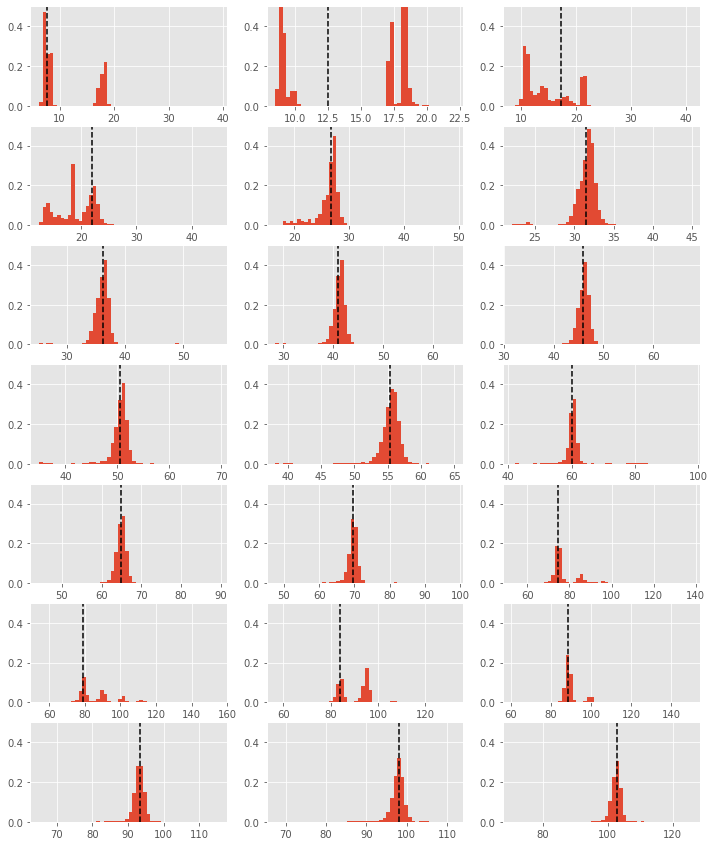

In [7]:
plt.figure(1, figsize=(12, 15))

for n_threads in range(1, 22):
    df = TT_df[(TT_df.test == 'startTask') & (TT_df.N_threads == n_threads)]

    if n_threads == 1:
        subp = plt.subplot(7, 3, n_threads)
    else:
        plt.subplot(7, 3, n_threads)
    for i in range(1):
        plt.axvline(np.polyval(fit_start, n_threads) + i*11, color='black', linestyle='--')
    _ = plt.hist(df.wtime_us, bins=50, density=True)
    plt.ylim(0.0, 0.5)

### Estimate Orchestration Runtime Overhead

Data was acquired in serial mode with a one loop over blocks for each of the three tasks.  In addition, data was also acquired with three serial calls to the runtime with each call executing only one of the tasks.

In [8]:
def fit_T_serial_model(df, n_loops):
    data_df = df[  (df.pmode   == 'Serial') \
                 & (df.n_loops == n_loops)]

# Poorly conditioned model
#     A = np.full([len(data_df), 3], 0.0, dtype=float)
#     A[:, 0] = 1.0
#     A[:, 1] = data_df.N_BLOCKS_X.pow(2)
#     A[:, 2] = data_df.N_BLOCKS_X.pow(2) * data_df.NXB.pow(2)
# Appropriate model for the current data set
    A = np.full([len(data_df), 2], 0.0, dtype=float)
    A[:, 0] = data_df.N_BLOCKS_X.pow(2)
    A[:, 1] = data_df.N_BLOCKS_X.pow(2) * data_df.NXB.pow(2)
    b = data_df.wtime_mean.values

    model, residual_norm_sqr, rank, sing_vals = np.linalg.lstsq(A, b, rcond=None)
    assert(rank == A.shape[1])
    kappa_2 = sing_vals[0] / sing_vals[-1]

    # Sanity check fit and evaluation routines!
    samples = list(zip(data_df.N_BLOCKS_X, data_df.NXB))
    residual = b - T_serial(samples, model)
    assert(np.abs(  residual_norm_sqr \
                  - np.linalg.norm(residual, ord=2)**2) < 1.0e-15)

#    print(f'{model[0]:.3g} + {model[1]:.3g}*N_blks_x^2 + {model[2]:.3g}*N_blk_x^2*N_cells_x^2')
    print(f'T_serial(N_blks_x, N_cells_x; d=2) = {model[0]:.3g}*N_blks_x^2 + {model[1]:.3g}*N_blk_x^2*N_cells_x^2')
    print(f'Condition Number\t{kappa_2:g}')
    print(f'||Ax - b||_2\t\t{residual_norm_sqr[0]:g}')
    print(f'Block overhead\t\t{model[0] * 1.0e6} us/block')
    print(f'Computation time\t{model[1] * 1.0e6} us/cell')

    return model

def T_serial(samples, p):
    T = np.zeros(len(samples))
    for j, (N_blks_x, N_cells_x) in enumerate(samples):
#        T[j] = p[0] + p[1]*N_blks_x**2+ p[2]*N_blks_x**2*N_cells_x**2
        T[j] = p[0]*N_blks_x**2+ p[1]*N_blks_x**2*N_cells_x**2

    return T


Serial Walltime Model
--------------------------------------------------------------------------------
T_serial(N_blks_x, N_cells_x; d=2) = 7.56e-06*N_blks_x^2 + 1.71e-07*N_blk_x^2*N_cells_x^2
Condition Number	9263.67
||Ax - b||_2		8.98627e-05
Block overhead		7.556275688841592 us/block
Computation time	0.17056753076756057 us/cell

The runtime overhead becomes negligible if the T_serial > 2.0 ms


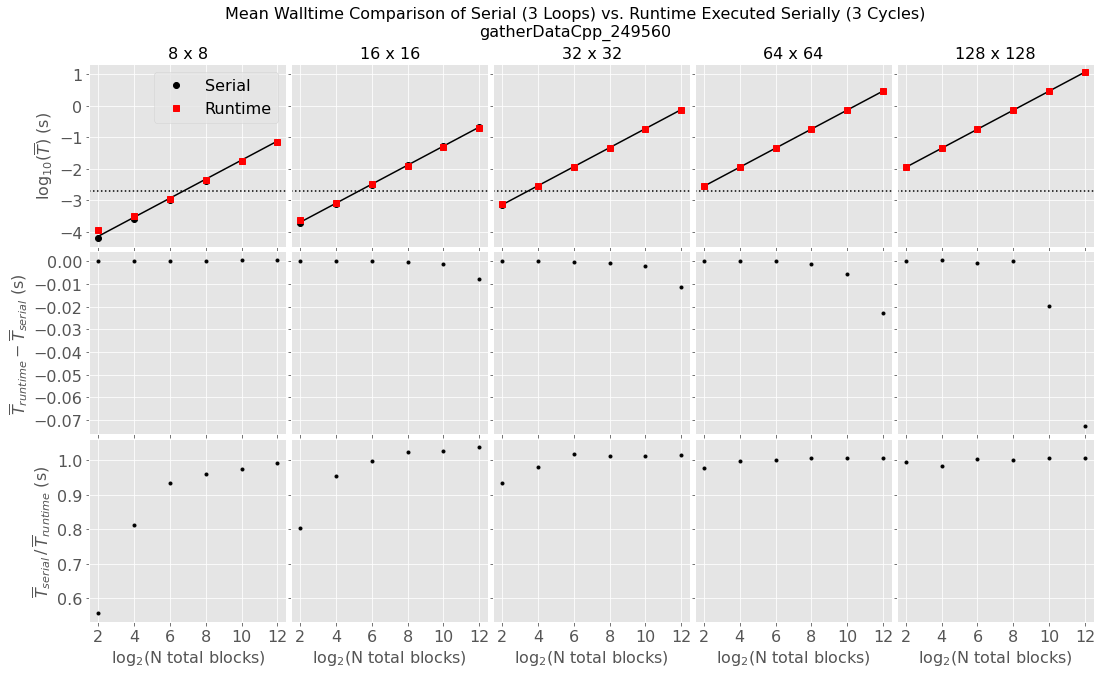

In [9]:
START_IDX = 3
N_LOOPS = 3

print()
print('Serial Walltime Model')
print('-' * 80)
T_serial_model = fit_T_serial_model(cpp_df, N_LOOPS)

nxb_all = sorted(cpp_df.NXB.unique())
serial = {}
runtime = {}
serial_fit  = {}
runtime_fit = {}
for nxb in nxb_all:
    df = cpp_df[  (cpp_df.pmode == 'Serial') \
                & (cpp_df.n_loops == N_LOOPS) \
                & (cpp_df.NXB == nxb)]
    serial_df = df.sort_values(by=['N_BLOCKS_X'])

    df = cpp_df[  (cpp_df.pmode == 'Runtime') \
                & (cpp_df.n_loops == N_LOOPS) \
                & (cpp_df.NXB == nxb)]
    runtime_df = df.sort_values(by=['N_BLOCKS_X'])

    serial[nxb]  = serial_df
    runtime[nxb] = runtime_df
    
print()
print(f'The runtime overhead becomes negligible if the T_serial > {GATHER_CPP_SERIAL_THOLD_SEC*1.0e3} ms')

title  = 'Mean Walltime Comparison of Serial (3 Loops) vs. Runtime Executed Serially (3 Cycles)\n'
title += str(GATHER_CPP_PATH)
    
plt.figure(3, figsize=(18, 10))
plt.suptitle(title, fontsize=FONTSIZE)
plt.subplots_adjust(top=0.9, hspace=0.025, wspace=0.025)

n_nxb = len(nxb_all)
for j, nxb in enumerate(nxb_all):
    X_DATA = range(2, 13)
    N_BLKS_X = [pow(2.0, n) for n in np.linspace(1, 6, 100)]
    N_BLKS = [n**2 for n in N_BLKS_X]
    SAMPLES = list(zip(N_BLKS_X, [nxb]*len(N_BLKS_X)))

    if j == 0:
        subp1 = plt.subplot(3, n_nxb, j + 1)
    else:
        plt.subplot(3, n_nxb, j + 1, sharex=subp1, sharey=subp1)
    plt.title(f'{nxb} x {nxb}', fontsize=FONTSIZE)
    plt.plot(np.log2(serial[nxb].N_BLOCKS_X.pow(2)), \
             np.log10(serial[nxb].wtime_mean), \
             'ok', label='Serial')
#    plt.plot(X_DATA, np.polyval(serial_fit[nxb], X_DATA), '-k')
    plt.plot(np.log2(N_BLKS), \
             np.log10(T_serial(SAMPLES, T_serial_model)), '-k')
    plt.plot(np.log2(runtime[nxb].N_BLOCKS_X.pow(2)), \
             np.log10(runtime[nxb].wtime_mean), \
             'sr', label='Runtime')
#     plt.plot(X_DATA, np.polyval(runtime_fit[nxb], X_DATA), '-r')
    plt.axhline(np.log10(GATHER_CPP_SERIAL_THOLD_SEC), color='black', linestyle='dotted')
    plt.grid(True)
    for each in plt.gca().get_xticklabels():
        each.set_visible(False)
    if j == 0:
        plt.legend(loc='best', fontsize=FONTSIZE)
        plt.ylabel(r'$\log_{10}(\overline{T})$ (s)', fontsize=FONTSIZE)
        for each in plt.gca().get_yticklabels():
            each.set_fontsize(FONTSIZE)
    else:
        for each in plt.gca().get_yticklabels():
            each.set_visible(False)

    if j == 0:
        subp2 = plt.subplot(3, n_nxb, n_nxb+j+1, sharex=subp1)
    else:
        plt.subplot(3, n_nxb, n_nxb+j+1, sharex=subp1, sharey=subp2)
    plt.plot(np.log2(serial[nxb].N_BLOCKS_X.pow(2)), \
             runtime[nxb].wtime_mean.values - serial[nxb].wtime_mean.values, '.k')
    plt.grid(True)
    for each in plt.gca().get_xticklabels():
        each.set_visible(False)
    if j == 0:
        plt.ylabel(r'$\overline{T}_{runtime} - \overline{T}_{serial}$ (s)', fontsize=FONTSIZE)
        for each in plt.gca().get_yticklabels():
            each.set_fontsize(FONTSIZE)
    else:
        for each in plt.gca().get_yticklabels():
            each.set_visible(False)

    if j == 0:
        subp3 = plt.subplot(3, n_nxb, 2*n_nxb+j+1, sharex=subp1)
    else:
        plt.subplot(3, n_nxb, 2*n_nxb+j+1, sharex=subp1, sharey=subp3)
    plt.plot(np.log2(runtime[nxb].N_BLOCKS_X.pow(2)), \
             serial[nxb].wtime_mean.values / runtime[nxb].wtime_mean.values, '.k')
    plt.xlabel(r'$\log_2($N total blocks$)$', fontsize=FONTSIZE)
    plt.grid(True)
    for each in plt.gca().get_xticklabels():
        each.set_fontsize(FONTSIZE)
    if j == 0:
        plt.ylabel(r'$\overline{T}_{serial}\, /\, \overline{T}_{runtime}$ (s)', fontsize=FONTSIZE)
        for each in plt.gca().get_yticklabels():
            each.set_fontsize(FONTSIZE)
    else:
        for each in plt.gca().get_yticklabels():
            each.set_visible(False)

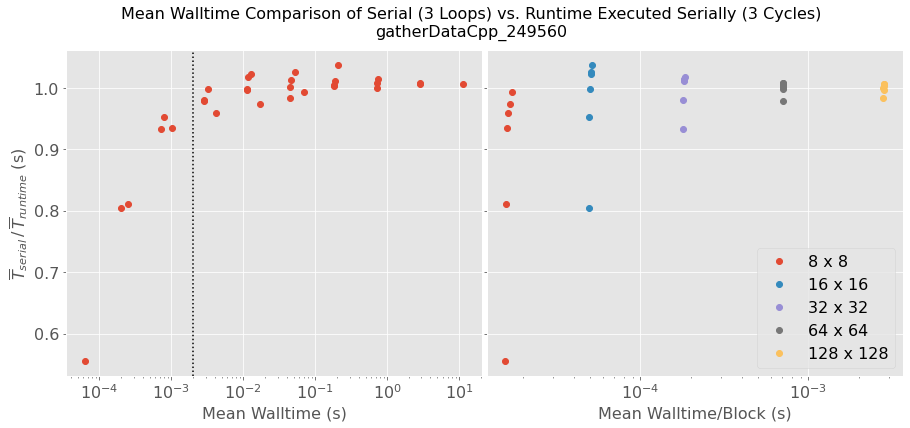

In [10]:
wtime_mean = []
data_per_block = {}
speedup = []

nxb_all = sorted(cpp_df.NXB.unique())
n_blocks_x_all = sorted(cpp_df.N_BLOCKS_X.unique())
for nxb in nxb_all:
    data_per_block[nxb] = []
    for n_blocks_x in n_blocks_x_all:
        s_df = serial[nxb]
        s_df = s_df[s_df.N_BLOCKS_X == n_blocks_x]
        r_df = runtime[nxb]
        r_df = r_df[r_df.N_BLOCKS_X == n_blocks_x]
        assert(len(s_df) == 1)
        assert(len(r_df) == 1)

        s_up = s_df.iloc[0].wtime_mean / r_df.iloc[0].wtime_mean
        n_total_blocks = n_blocks_x**2
        
        wtime_mean.append( s_df.iloc[0].wtime_mean )
        speedup.append( s_up )
    
        data_per_block[nxb].append( (s_df.iloc[0].wtime_mean / float(n_total_blocks), s_up) )

title  = 'Mean Walltime Comparison of Serial (3 Loops) vs. Runtime Executed Serially (3 Cycles)\n'
title += str(GATHER_CPP_PATH)
        
plt.figure(10, figsize=(15, 6))
plt.suptitle(title, fontsize=FONTSIZE)
plt.subplots_adjust(top=0.88, wspace=0.01)

subp = plt.subplot(121)
plt.semilogx(wtime_mean, speedup, 'o')
plt.axvline(GATHER_CPP_SERIAL_THOLD_SEC, color='black', linestyle='dotted')
plt.xlabel('Mean Walltime (s)', fontsize=FONTSIZE)
plt.ylabel(r'$\overline{T}_{serial}\, /\, \overline{T}_{runtime}$ (s)', fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)

plt.subplot(122, sharey=subp)
for nxb in nxb_all:
    t, s_up = zip(*data_per_block[nxb])
    plt.semilogx(t, s_up, 'o', label=f'{nxb} x {nxb}')
plt.xlabel('Mean Walltime/Block (s)', fontsize=FONTSIZE)
plt.legend(loc='best', fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_visible(False)

### Estimate runtime vs. serial walltime evolution with total number of blocks

T_serial(N_blks_x, N_cells_x; d=2) = 4.72e-06*N_blks_x^2 + 1.7e-07*N_blk_x^2*N_cells_x^2
Condition Number	9263.67
||Ax - b||_2		5.39568e-05
Block overhead		4.722658835122237 us/block
Computation time	0.17027655227092175 us/cell
[ 0.95946134 -4.96408062]
[ 0.95921013 -4.92446075]
[ 0.94957723 -4.703602  ]
[ 0.99763837 -4.2793697 ]
[ 0.90552799 -3.42649891]


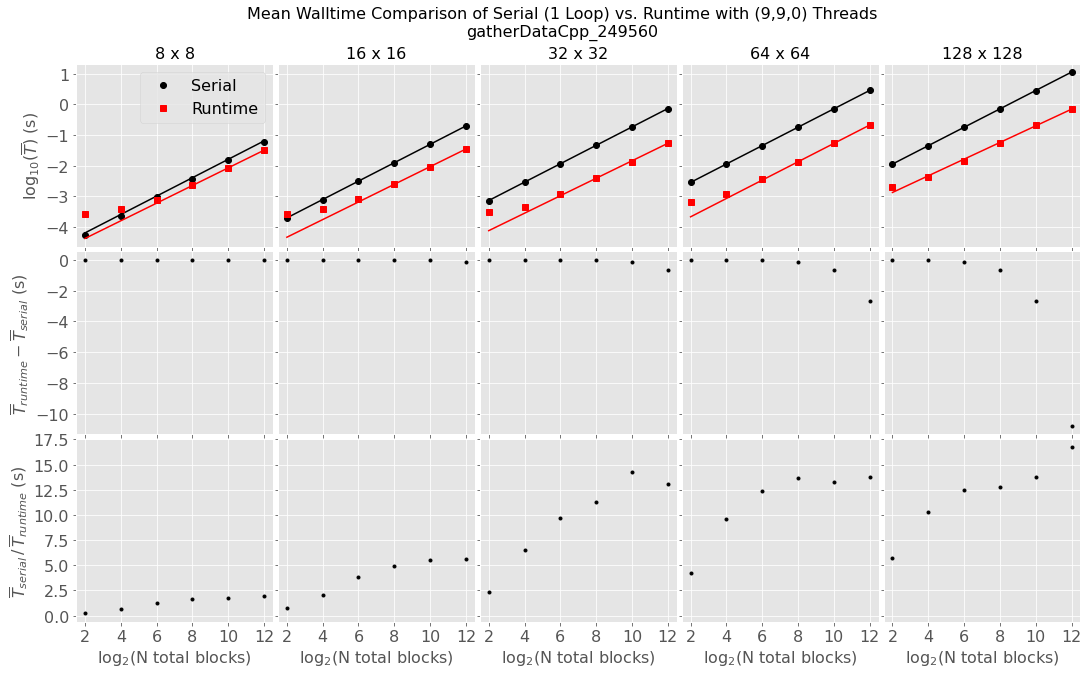

In [11]:
N_LOOPS = 1
N_THD_TASK1 = 9
N_THD_TASK2 = N_THD_TASK1
N_THD_TASK3 = 0

T_serial_model = fit_T_serial_model(cpp_df, N_LOOPS)

nxb_all = sorted(cpp_df.NXB.unique())
serial = {}
runtime = {}
runtime_fit = {}
for nxb in nxb_all:
    df = cpp_df[  (cpp_df.pmode == 'Serial') \
                & (cpp_df.n_loops == N_LOOPS) \
                & (cpp_df.NXB == nxb)]
    serial_df = df.sort_values(by=['N_BLOCKS_X'])

    df = cpp_df[  (cpp_df.pmode == 'Runtime') \
                & (cpp_df.n_loops == N_LOOPS) \
                & (cpp_df.NXB == nxb) \
                & (cpp_df.n_thd_task1 == N_THD_TASK1) \
                & (cpp_df.n_thd_task2 == N_THD_TASK2) \
                & (cpp_df.n_thd_task3 == N_THD_TASK3)]
    runtime_df = df.sort_values(by=['N_BLOCKS_X'])

    serial[nxb]  = serial_df
    runtime[nxb] = runtime_df

    N_blks = runtime_df.N_BLOCKS_X.pow(2).values
    Wtime = runtime_df.wtime_mean.values
    runtime_fit[nxb] = np.polyfit(np.log10(N_blks[3:]), \
                                  np.log10(Wtime[3:]), \
                                  deg=1)
    print(runtime_fit[nxb])
    runtime_fit[nxb][0] *= np.log10(2.0)

title  = 'Mean Walltime Comparison of Serial (1 Loop) vs. Runtime with ({},{},{}) Threads\n'
title  = title.format(N_THD_TASK1, N_THD_TASK2, N_THD_TASK3)
title += str(GATHER_CPP_PATH)
    
plt.figure(3, figsize=(18, 10))
plt.suptitle(title, fontsize=FONTSIZE)
plt.subplots_adjust(top=0.9, hspace=0.025, wspace=0.025)

n_nxb = len(nxb_all)
for j, nxb in enumerate(nxb_all):
    X_DATA = range(2, 13)
    N_BLKS_X = [pow(2.0, n) for n in np.linspace(1, 6, 100)]
    N_BLKS = [n**2 for n in N_BLKS_X]
    SERIAL_SAMPLES = list(zip(N_BLKS_X, [nxb]*len(N_BLKS_X)))

    if j == 0:
        subp1 = plt.subplot(3, n_nxb, j + 1)
    else:
        plt.subplot(3, n_nxb, j + 1, sharex=subp1, sharey=subp1)
    plt.title(f'{nxb} x {nxb}', fontsize=FONTSIZE)
    plt.plot(np.log2(serial[nxb].N_BLOCKS_X.pow(2)), \
             np.log10(serial[nxb].wtime_mean), \
             'ok', label='Serial')
    plt.plot(np.log2(N_BLKS), \
             np.log10(T_serial(SERIAL_SAMPLES, T_serial_model)), '-k')
    plt.plot(np.log2(runtime[nxb].N_BLOCKS_X.pow(2)), \
             np.log10(runtime[nxb].wtime_mean), \
             'sr', label='Runtime')
    plt.plot(np.log2(N_BLKS), \
             np.polyval(runtime_fit[nxb], np.log2(N_BLKS)), '-r')
    plt.grid(True)
    for each in plt.gca().get_xticklabels():
        each.set_visible(False)
    if j == 0:
        plt.legend(loc='best', fontsize=FONTSIZE)
        plt.ylabel(r'$\log_{10}(\overline{T})$ (s)', fontsize=FONTSIZE)
        for each in plt.gca().get_yticklabels():
            each.set_fontsize(FONTSIZE)
    else:
        for each in plt.gca().get_yticklabels():
            each.set_visible(False)

    if j == 0:
        subp2 = plt.subplot(3, n_nxb, n_nxb+j+1, sharex=subp1)
    else:
        plt.subplot(3, n_nxb, n_nxb+j+1, sharex=subp1, sharey=subp2)
    plt.plot(np.log2(serial[nxb].N_BLOCKS_X.pow(2)), \
             runtime[nxb].wtime_mean.values - serial[nxb].wtime_mean.values, '.k')
    plt.grid(True)
    for each in plt.gca().get_xticklabels():
        each.set_visible(False)
    if j == 0:
        plt.ylabel(r'$\overline{T}_{runtime} - \overline{T}_{serial}$ (s)', fontsize=FONTSIZE)
        for each in plt.gca().get_yticklabels():
            each.set_fontsize(FONTSIZE)
    else:
        for each in plt.gca().get_yticklabels():
            each.set_visible(False)

    if j == 0:
        subp3 = plt.subplot(3, n_nxb, 2*n_nxb+j+1, sharex=subp1)
    else:
        plt.subplot(3, n_nxb, 2*n_nxb+j+1, sharex=subp1, sharey=subp3)
    plt.plot(np.log2(runtime[nxb].N_BLOCKS_X.pow(2)), \
             serial[nxb].wtime_mean.values / runtime[nxb].wtime_mean.values, '.k')
    plt.xlabel(r'$\log_2($N total blocks$)$', fontsize=FONTSIZE)
    plt.grid(True)
    for each in plt.gca().get_xticklabels():
        each.set_fontsize(FONTSIZE)
    if j == 0:
        plt.ylabel(r'$\overline{T}_{serial}\, /\, \overline{T}_{runtime}$ (s)', fontsize=FONTSIZE)
        for each in plt.gca().get_yticklabels():
            each.set_fontsize(FONTSIZE)
    else:
        for each in plt.gca().get_yticklabels():
            each.set_visible(False)

N_B=4 / N_eff(N_B)=0.7051321866670917
N_B=16 / N_eff(N_B)=1.5533760693853593
N_B=64 / N_eff(N_B)=5.1256777089006516
N_B=256 / N_eff(N_B)=20.034722294721035
N_B=1024 / N_eff(N_B)=74.47838694482016
N_B=4096 / N_eff(N_B)=244.8359137077831


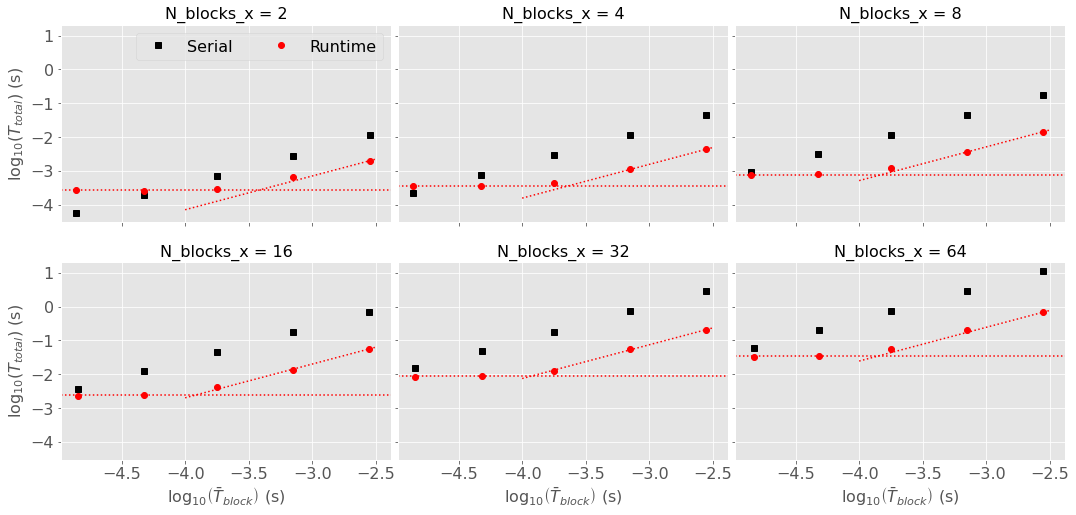

In [12]:
nxb_all = sorted(cpp_df.NXB.unique())
n_blks_x_all = sorted(cpp_df.N_BLOCKS_X.unique())

wtime_serial  = {}
wtime_rt      = {}
wtime_per_blk = {}
for n_blks_x in n_blks_x_all:
    wtime_serial[n_blks_x] = []
    wtime_rt[n_blks_x] = []
    wtime_per_blk[n_blks_x] = []

    for nxb in nxb_all:
        s_df = serial[nxb]
        s_df = s_df[s_df.N_BLOCKS_X == n_blks_x]
        assert(len(s_df) == 1)

        r_df = runtime[nxb]
        r_df = r_df[r_df.N_BLOCKS_X == n_blks_x]
        assert(len(r_df) == 1)

        wtime_serial[n_blks_x].append( s_df.iloc[0].wtime_mean )
        wtime_rt[n_blks_x].append( r_df.iloc[0].wtime_mean )
        wtime_per_blk[n_blks_x].append( s_df.iloc[0].wtime_mean / float(n_blks_x**2) )

    fit = np.polyfit(np.log10(wtime_per_blk[n_blks_x]), \
                     np.log10(wtime_serial[n_blks_x]), 1)
    assert(np.abs(fit[0] - 1.0) < 1.0e-14)
    assert(np.abs(np.power(10.0, fit[1]) - n_blks_x**2) < 1.0e-8)

plt.figure(10, figsize=(18, 8))
plt.subplots_adjust(wspace=0.02)

N_eff  = np.full(len(n_blks_x_all), 0.0, dtype=float)
T_lbdd = np.full(len(n_blks_x_all), 0.0, dtype=float)
T_c    = np.full(len(n_blks_x_all), 0.0, dtype=float)
for j, n_blks_x in enumerate(n_blks_x_all):
    N_eff[j] = wtime_rt[n_blks_x][-1] / wtime_per_blk[n_blks_x][-1]
    print(f'N_B={n_blks_x**2} / N_eff(N_B)={N_eff[j]}')
    X_DATA = np.logspace(-4, -2.5, 5)
    Y_DATA = [N_eff[j] * T_b for T_b in X_DATA]
    
    T_lbdd[j] = np.mean(wtime_rt[n_blks_x][:2])
    T_c[j]    = T_lbdd[j] / float(N_eff[j])

    if j == 0:
        subp = plt.subplot(2, 3, j+1)
    else:
        plt.subplot(2, 3, j+1, sharex=subp, sharey=subp)
    plt.title(f'N_blocks_x = {n_blks_x}', fontsize=FONTSIZE)
    plt.plot(np.log10(wtime_per_blk[n_blks_x]), \
             np.log10(wtime_serial[n_blks_x]), \
             'sk', label='Serial')
    plt.plot(np.log10(wtime_per_blk[n_blks_x]), \
             np.log10(wtime_rt[n_blks_x]), \
             'ro', label='Runtime')
    plt.plot(np.log10(X_DATA), \
             np.log10(Y_DATA), \
             'r', linestyle='dotted')
    plt.axhline(np.log10(T_lbdd[j]), \
                color='red', linestyle='dotted')
    if j == 0:
        plt.legend(ncol=2, loc='best', fontsize=FONTSIZE)
    if j < 3:
        for each in plt.gca().get_xticklabels():
            each.set_visible(False)
    else:
        plt.xlabel(r'$\log_{10}\left(\bar{T}_{block}\right)$ (s)', fontsize=FONTSIZE)
        for each in plt.gca().get_xticklabels():
            each.set_fontsize(FONTSIZE)
    if j in [0, 3]:
        plt.ylabel(r'$\log_{10}\left(T_{total}\right)$ (s)', fontsize=FONTSIZE)
        for each in plt.gca().get_yticklabels():
            each.set_fontsize(FONTSIZE)
    else:
        for each in plt.gca().get_yticklabels():
            each.set_visible(False)

For a fixed total number of blocks, $N_B$, a fit to the serial data gives exactly
\\[
T^s_\textrm{total}(\bar{T}_\textrm{block}; N_B) = N_B \bar{T}_\textrm{block}
\\]
as expected.  It assume that for $\bar{T}_\textrm{block}$ large enough, the runtime data is well modeled by
\\[
T^r_\textrm{total}(\bar{T}_\textrm{block}; N_B) = N_\textrm{eff}(N_B) \bar{T}_\textrm{block},
\\]
where $N_\textrm{eff}(N)$ is our function of interest.  Based on this assumption, I interpolate the largest walltime/block result with a line of the desired slope.

My interpretation of $N_\textrm{eff}$ is therefore as the number of blocks it appears that the runtime is handling.  If this number is less than $N_B$, then the runtime is helping us.  We note, however, that the runtime's ability to hide blocks begins to suffer when $\bar{T}_B$ becomes to small.  Below the cut-off value, the total walltime is fixed.  When we do not have enough blocks to wind-up/-down the runtime's pipeline, then below this cutoff we find that indeed the runtime becomes inefficient.  With, however, a sufficient total number of blocks, the runtime can still be efficient below the cutoff.

Finally, note that the floor on total runtime increases with increasing number of blocks.  I am currently interpreting this as an estimate on the overhead associated with queueing/dequeueing blocks.

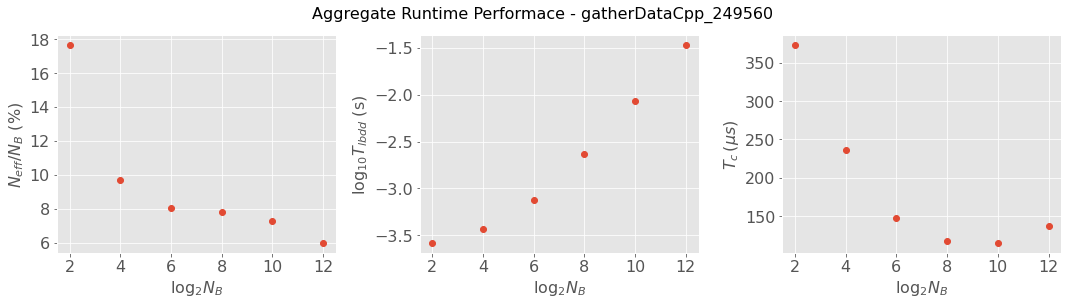

In [13]:
n_blks = [e**2 for e in n_blks_x_all]
fraction = [N_e / N * 100.0 for N, N_e in zip(n_blks, N_eff)]

plt.figure(30, figsize=(18, 4))
plt.suptitle(f'Aggregate Runtime Performace - {GATHER_CPP_PATH}', fontsize=FONTSIZE)
plt.subplots_adjust(wspace=0.3)

plt.subplot(131)
plt.plot(np.log2(n_blks), fraction, 'o')
plt.xlabel(r'$\log_2 N_B$', fontsize=FONTSIZE)
_ = plt.ylabel(r'$N_{eff} / N_B$ (%)', fontsize=FONTSIZE)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)
    
plt.subplot(132)
plt.plot(np.log2(n_blks), np.log10(T_lbdd), 'o')
plt.xlabel(r'$\log_2 N_B$', fontsize=FONTSIZE)
_ = plt.ylabel(r'$\log_{10} T_{lbdd}$ (s)', fontsize=FONTSIZE)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)
    
plt.subplot(133)
plt.plot(np.log2(n_blks), T_c * 1.0e6, 'o')
plt.xlabel(r'$\log_2 N_B$', fontsize=FONTSIZE)
_ = plt.ylabel(r'$T_c\, (\mu s)$', fontsize=FONTSIZE)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)

In [14]:
df= cpp_df[  (cpp_df.pmode == 'Runtime') \
           & (cpp_df.n_loops == 1) \
           & (cpp_df.n_thd_task3 == 0)]
n_thds_all = sorted(df.n_thd_task1.unique())
n_thds_all = n_thds_all[:-1]

nxb_all = sorted(cpp_df.NXB.unique())
nxb_all
n_blocks_all = sorted(cpp_df.N_BLOCKS_X.unique())

speedup_0 = np.zeros([len(nxb_all), len(n_blocks_all), len(n_thds_all)])
speedup_1 = np.zeros([len(nxb_all), len(n_blocks_all), len(n_thds_all)])
for k, t in enumerate(n_thds_all):
    for i, nxb in enumerate(nxb_all):
        serial_df = cpp_df[  (cpp_df.pmode == 'Serial') \
                           & (cpp_df.n_loops     == 1) \
                           & (cpp_df.n_thd_task1 == 0) \
                           & (cpp_df.n_thd_task2 == 0) \
                           & (cpp_df.n_thd_task3 == 0) \
                           & (cpp_df.NXB == nxb)]
        runtime_df = cpp_df[  (cpp_df.pmode == 'Runtime') \
                            & (cpp_df.n_loops     == 1) \
                            & (cpp_df.n_thd_task1 == t) \
                            & (cpp_df.n_thd_task2 == t)
                            & (cpp_df.NXB == nxb)]
        for j, n_blocks_x in enumerate(n_blocks_all):
            s_df = serial_df[serial_df.N_BLOCKS_X == n_blocks_x]
            r_0_df = runtime_df[  (runtime_df.N_BLOCKS_X == n_blocks_x) \
                                & (runtime_df.n_thd_task3 == 0)]
            r_1_df = runtime_df[  (runtime_df.N_BLOCKS_X == n_blocks_x) \
                                & (runtime_df.n_thd_task3 == 1)]
            assert(len(s_df) == 1)
            assert(len(r_0_df) == 1)
            assert(len(r_1_df) == 1)
            speedup_0[i, j, k] =   s_df.iloc[0].wtime_mean / r_0_df.iloc[0].wtime_mean
            speedup_1[i, j, k] =   s_df.iloc[0].wtime_mean / r_1_df.iloc[0].wtime_mean

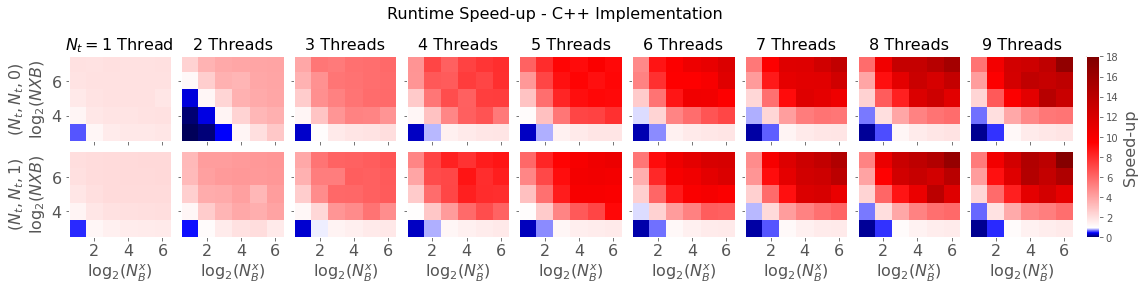

In [15]:
N_ROWS = 2
N_COLS = len(n_thds_all)

# Set colorbar so that speed-up=1 is white
#  => runtime slower is shade of blue
#  => runtime faster is shade of red
s_max = np.max([np.max(speedup_0.flatten()), 
                np.max(speedup_1.flatten())])
s_min = np.min([np.min(speedup_0.flatten()), 
                np.min(speedup_1.flatten())])
vmax = np.ceil(s_max)
vmin = 0.0

speedup_cmap = customize_speedup_cmap(vmax, N=1024)

fig = plt.figure(10, figsize=(18, 3.75))
plt.suptitle('Runtime Speed-up - C++ Implementation', fontsize=FONTSIZE)
plt.subplots_adjust(top=0.8, hspace=0.1, wspace=0.1)

extents = [np.log2(n_blocks_all[0]) - 0.5, np.log2(n_blocks_all[-1]) + 0.5, \
           np.log2(nxb_all[0])      - 0.5, np.log2(nxb_all[-1])      + 0.5]

for i, n_thds in enumerate(n_thds_all):
    subp = plt.subplot(N_ROWS, N_COLS, i+1)
    if i == 0:
        plt.title(r'$N_t=1$ Thread', fontsize=FONTSIZE)
    else:
        plt.title('{} Threads'.format(n_thds_all[i]), fontsize=FONTSIZE)
    plt.imshow(speedup_0[:, :, i], origin='lower', \
               cmap=speedup_cmap, vmax=vmax, vmin=vmin, \
               extent=extents)
    plt.grid(False)
    for each in plt.gca().get_xticklabels():
        each.set_visible(False)
    if i > 0:
        for each in plt.gca().get_yticklabels():
            each.set_visible(False)
    else:
        title  = r'$(N_t,N_t,0)$' + '\n' + r'$\log_2(NXB)$'
        plt.ylabel(title, fontsize=FONTSIZE)
        for each in plt.gca().get_yticklabels():
            each.set_fontsize(FONTSIZE)
    
    plt.subplot(N_ROWS, N_COLS, i+N_COLS+1)
    img = plt.imshow(speedup_1[:, :, i], origin='lower', \
               cmap=speedup_cmap, vmax=vmax, vmin=vmin, \
               extent=extents)
    plt.xlabel(r'$\log_2(N_B^x)$', fontsize=FONTSIZE)
    plt.grid(False)
    for each in plt.gca().get_xticklabels():
        each.set_fontsize(FONTSIZE)
    if i > 0:
        for each in plt.gca().get_yticklabels():
            each.set_visible(False)
    else:
        title  = r'$(N_t,N_t,1)$' + '\n' + r'$\log_2(NXB)$'
        plt.ylabel(title, fontsize=FONTSIZE)
        for each in plt.gca().get_yticklabels():
            each.set_fontsize(FONTSIZE)

cbaxes = fig.add_axes([0.91, 0.125, 0.01, 0.67]) 
cb = plt.colorbar(img, cax=cbaxes)
cb.set_label('Speed-up', fontsize=FONTSIZE)

### Estimate overhead of Fortran wrapper

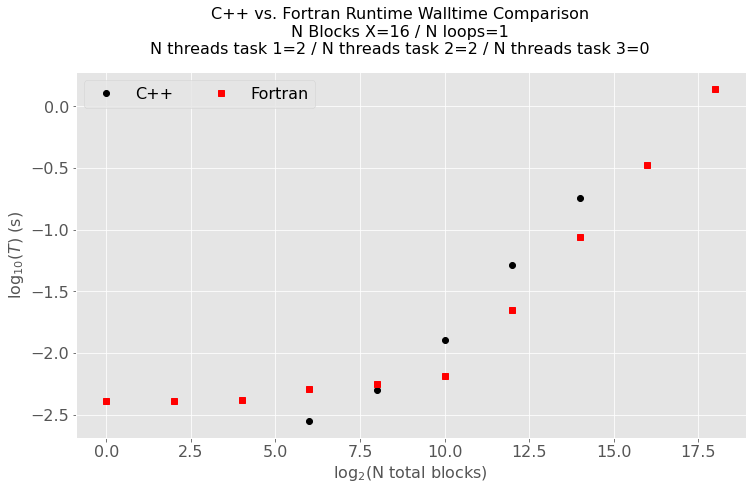

In [16]:
constant_values = ['pmode', 'n_loops', \
                   'n_thd_task1', 'n_thd_task2', 'n_thd_task3', \
                   'NZB', 'N_BLOCKS_X', 'N_BLOCKS_Y', 'N_BLOCKS_Z']
for key in constant_values:
    assert( len(f03_full_df[key].unique()) == 1 )

assert(f03_full_df.iloc[0].pmode == 'Runtime')

assert(all(f03_full_df.dx == f03_full_df.dy))
assert(all(f03_full_df.Linf_density <= 1.0e-15))

df = cpp_df[  (cpp_df.pmode       == f03_full_df.iloc[0].pmode) \
            & (cpp_df.n_loops     == f03_full_df.iloc[0].n_loops) \
            & (cpp_df.n_thd_task1 == f03_full_df.iloc[0].n_thd_task1) \
            & (cpp_df.n_thd_task2 == f03_full_df.iloc[0].n_thd_task2) \
            & (cpp_df.n_thd_task3 == f03_full_df.iloc[0].n_thd_task3) \
            & (cpp_df.N_BLOCKS_X  == f03_full_df.iloc[0].N_BLOCKS_X)]

title  = 'C++ vs. Fortran Runtime Walltime Comparison\n'
title += 'N Blocks X={} / N loops={}\n'
title += 'N threads task 1={} / N threads task 2={} / N threads task 3={}'
title = title.format(f03_full_df.iloc[0].N_BLOCKS_X, \
                     f03_full_df.iloc[0].n_loops, \
                     f03_full_df.iloc[0].n_thd_task1, \
                     f03_full_df.iloc[0].n_thd_task2, \
                     f03_full_df.iloc[0].n_thd_task3)
plt.figure(5, figsize=(12, 7))
plt.suptitle(title, fontsize=FONTSIZE)
plt.subplots_adjust(top=0.85)

plt.subplot(111)
plt.plot(np.log2(df.NXB.pow(2)),          np.log10(df.wtime_mean), \
         'ok', label='C++')
plt.plot(np.log2(f03_full_df.NXB.pow(2)), np.log10(f03_full_df.Walltime_sec), \
         'sr', label='Fortran')
plt.xlabel(r'$\log_2($N total blocks$)$', fontsize=FONTSIZE)
plt.ylabel(r'$\log_{10}(T)$ (s)', fontsize=FONTSIZE)
plt.legend(loc='best', ncol=2, fontsize=FONTSIZE)
plt.grid(True)
for each in plt.gca().get_xticklabels():
    each.set_fontsize(FONTSIZE)
for each in plt.gca().get_yticklabels():
    each.set_fontsize(FONTSIZE)